In [37]:
# !pip3 install scipy==1.1.0

In [38]:
import tensorflow as tf
tf.__version__

'2.0.0-beta0'

In [39]:
import keras
keras.__version__

'2.2.4'

In [40]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob # For pathname matching
from skimage.transform import resize
from keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Flatten,concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import cv2

from PIL import Image
from scipy import ndimage
import matplotlib.pyplot as plt
from scipy.misc import imresize

from time import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from matplotlib.pyplot import rc
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 12}
rc('font', **font)  # pass in the font dict as kwargs
# K.set_image_data_format('channels_first')

import os

In [41]:
# print (K.image_data_format())
# K.set_image_data_format('channels_first')
# print (K.image_data_format())

In [58]:
train = glob('./train/*.jpg')
train_masks = glob('./train_masks/*.gif')
test= glob('./test/*.jpg')
print ('Number of training images: ', len(train), '\nNumber of corresponding masks: ', len(train_masks))
print ('Number of test images: ', len(test))

Number of training images:  5088 
Number of corresponding masks:  5088
Number of test images:  52


In [43]:
#split the training set into train and validation samples
batch_size = 8
img_rows, img_cols = 1024,1024

train_images, validation_images = train_test_split(train, train_size=0.8)
print('Size of the training sample =', len(train_images), 
      'and size of the validation sample =', len(validation_images), 'images')

Size of the training sample = 4070 and size of the validation sample = 1018 images


In [44]:
print (np.random.choice(np.arange(len(train_images)), batch_size))
dims = dims = [1024, 1024]
print (dims + [3])

[3732  325 2593 2216  618 1733 1568 3245]
[1024, 1024, 3]


In [45]:
# !pip3 install scipy==1.2.0

In [46]:
import cv2
from scipy.misc import imresize
import matplotlib.pyplot as plt
from PIL import Image

In [47]:
#utility function to convert greyscale inages to rgb
def grey2rgb(img):
    new_img = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img.append(list(img[i][j])*3)
    new_img = np.array(new_img).reshape(img.shape[0], img.shape[1], 3)
    return new_img

#generator that will be used to read data from the directory
def data_generator(data_dir, masks, images, dims, batch_size=batch_size):
    while True:
        ix=np.random.choice(np.arange(len(images)), batch_size)
        imgs = []
        labels = []
        for i in ix:
            # images
            original_img = cv2.imread(images[i])
            resized_img = imresize(original_img, dims + [3]) 
            array_img = resized_img/255
            # array_img = array_img.swapaxes(0, 2)
            imgs.append(array_img)
            # imgs is a numpy array with dim: (batch size X 128 X 128 3)
            # print('shape of imgs ', array_img.shape)
            # masks
            try:
                file_name = images[i].split("/")[-1].replace(".jpg", "")
                correct_mask = './train_masks/' + file_name + '_mask.gif'
                original_mask = Image.open(correct_mask).convert('L')
                data = np.asarray(original_mask, dtype="int32")
                resized_mask = imresize(original_mask, dims+[3])
                array_mask = resized_mask / 255
                labels.append(array_mask)
            except Exception as e:
                labels=None
            
        imgs = np.array(imgs)
        labels = np.array(labels)
        try:
            relabel = labels.reshape(-1, dims[0], dims[1], 1)
            # relabel = relabel.swapaxes(1, 3)
        except Exception as e:
            relabel=labels
        yield imgs, relabel

In [48]:
train_gen = data_generator('train/', train_masks, train_images, dims=[img_rows, img_cols])
img, msk = next(train_gen)
print (img.shape)
print (msk.shape)

(8, 1024, 1024, 3)
(8, 1024, 1024, 1)


Text(0.5, 1.0, 'Training Image mask')

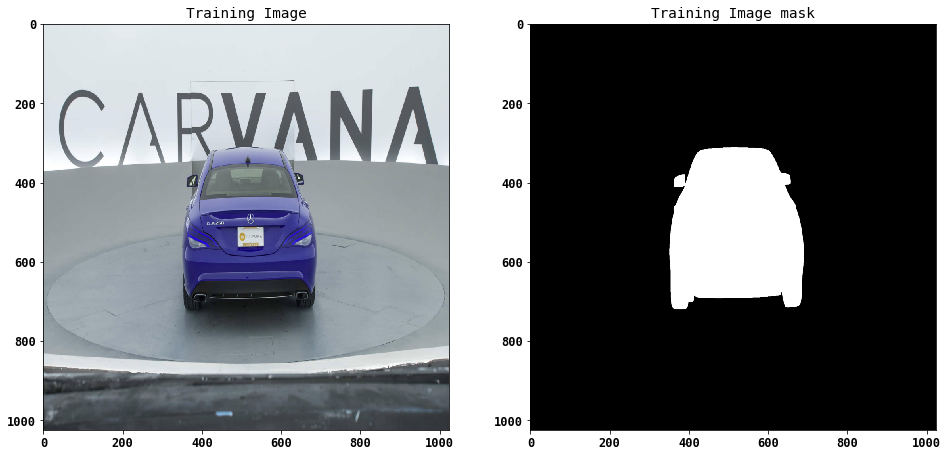

In [49]:
train_img = img[0]#.swapaxes(0,2)
train_msk = msk#.swapaxes(1,3)

fig, ax = plt.subplots(1,2, figsize=(16, 16))
ax = ax.ravel()
ax[0].imshow(train_img, cmap='gray') 
ax[0].set_title('Training Image')
ax[1].imshow(grey2rgb(train_msk[0]), cmap='gray')
ax[1].set_title('Training Image mask')

In [50]:
# create an instance of a validation generator:
validation_gen = data_generator('train/', train_masks, validation_images, dims=[img_rows, img_cols]) 

In [51]:
def dice_coef(y_true, y_pred, smooth=0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection=K.sum(y_true_f * y_pred_f)
    return(2. * intersection + smooth) / ((K.sum(y_true_f) + K.sum(y_pred_f)) + smooth)

In [52]:
# K.set_image_data_format("channels_first")
# K.set_image_dim_ordering("th")
# print (K.image_data_format())

In [53]:
print (img_rows, img_cols)
print (K.image_data_format())
def unet(input_size = (img_rows, img_cols, 3)):
    inputs = Input(input_size)
    conv0 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv0 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0)
    pool0 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv0)
    
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool0)
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv1)
    
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv2)
    
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv3)
    
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(drop4)

    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

    up6 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    up10 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv9))
    conv10 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up10)
    
    conv11 = Conv2D(1, 1, activation = 'sigmoid')(conv10)

    model = Model(inputs, conv11)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = [dice_coef])
    
    return model

# Build and compile the model
model = unet()
for layer in model.layers:
    print(layer.name, layer.output_shape)
model.summary()

1024 1024
channels_last
input_3 [(None, 1024, 1024, 3)]
conv2d_54 (None, 1024, 1024, 8)
conv2d_55 (None, 1024, 1024, 8)
max_pooling2d_10 (None, 512, 512, 8)
conv2d_56 (None, 512, 512, 16)
conv2d_57 (None, 512, 512, 16)
max_pooling2d_11 (None, 256, 256, 16)
conv2d_58 (None, 256, 256, 32)
conv2d_59 (None, 256, 256, 32)
max_pooling2d_12 (None, 128, 128, 32)
conv2d_60 (None, 128, 128, 64)
conv2d_61 (None, 128, 128, 64)
max_pooling2d_13 (None, 64, 64, 64)
conv2d_62 (None, 64, 64, 128)
conv2d_63 (None, 64, 64, 128)
dropout_2 (None, 64, 64, 128)
max_pooling2d_14 (None, 32, 32, 128)
conv2d_64 (None, 32, 32, 256)
conv2d_65 (None, 32, 32, 256)
up_sampling2d_10 (None, 64, 64, 256)
conv2d_66 (None, 64, 64, 128)
concatenate_8 (None, 64, 64, 256)
conv2d_67 (None, 64, 64, 128)
conv2d_68 (None, 64, 64, 128)
up_sampling2d_11 (None, 128, 128, 128)
conv2d_69 (None, 128, 128, 64)
concatenate_9 (None, 128, 128, 128)
conv2d_70 (None, 128, 128, 64)
conv2d_71 (None, 128, 128, 64)
up_sampling2d_12 (None, 256, 

In [54]:
model.load_weights('saved_model.h5')

In [18]:
# !pip3 install -q pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
# model_save = ModelCheckpoint('best_model.hdf5', save_best_only=True, mode='min')
# model_run = model.fit_generator(train_gen, steps_per_epoch=50, epochs=10,
#                                 validation_data=validation_gen, validation_steps=50, callbacks=[model_save])

# model.save("saved_model.h5")

Text(0.5, 1.0, 'Validation Image mask')

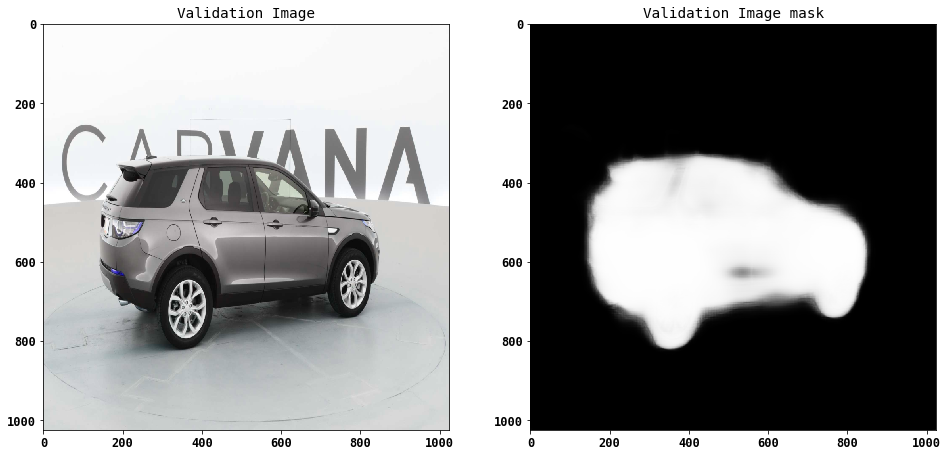

In [55]:
img, msk = next(validation_gen)
predicted_mask = model.predict(img)#.swapaxes(1,3)
validation_image = img[0]#.swapaxes(0,2)

fig, ax = plt.subplots(1,2, figsize=(16, 16))
ax = ax.ravel()
ax[0].imshow(validation_image, cmap='gray') 
ax[0].set_title('Validation Image')
ax[1].imshow(grey2rgb(predicted_mask[0]), cmap='gray')
ax[1].set_title('Validation Image mask')

Text(0.5, 1.0, 'Test Image mask')

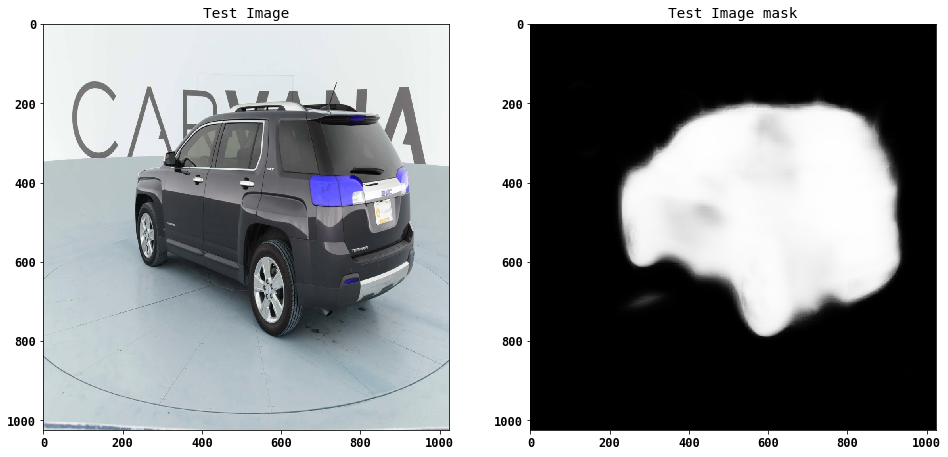

In [60]:
test_set = data_generator('test/', train_masks, test, dims=[img_rows, img_cols]) 
img_tst, msk_tst = next(test_set)
predicted_mask_tst = model.predict(img_tst)
predicted_mask_tst = predicted_mask_tst#.swapaxes(1,3)
test_mask = grey2rgb(predicted_mask_tst[0])

test_image = img_tst[0]#.swapaxes(0,2) 

fig, ax = plt.subplots(1,2, figsize=(16, 16))
ax = ax.ravel()
ax[0].imshow(test_image, cmap='gray') 
ax[0].set_title('Test Image')
ax[1].imshow(test_mask, cmap='gray')
ax[1].set_title('Test Image mask')